In [481]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, interactive, fixed, interact_manual
import calendar

sns.set()

# Make charts a bit bolder
sns.set_context("talk")


In [482]:
%matplotlib inline

plt.style.use('fivethirtyeight')

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

# Define a common date format
DATE_FORMAT = "%d.%m.%Y" 

sns.set(rc={"figure.figsize": (12, 6)})

/Users/mihailojoksimovic/miniconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


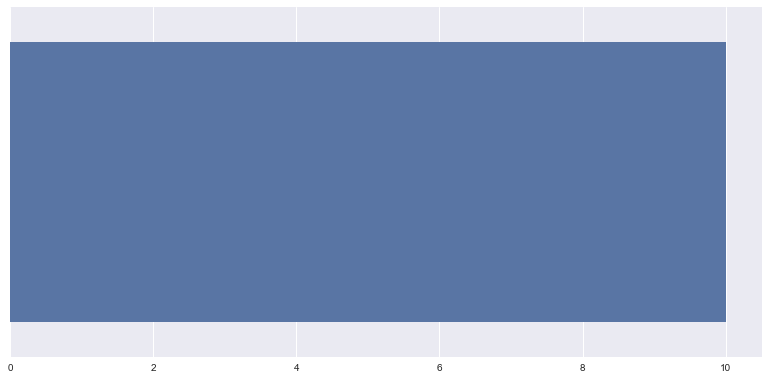

In [483]:
sns.barplot([10])

In [484]:
data = pd.read_csv('globalterrorismdb.csv', encoding='latin1', index_col='eventid')



/Users/mihailojoksimovic/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (4,6,31,33,53,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [485]:
data.rename(columns={'iyear':'Year','imonth':'Month','iday':'Day','country_txt':'Country','region_txt':'Region','attacktype1_txt':'AttackType','target1':'Target','nkill':'Killed','nwound':'Wounded','summary':'Summary','gname':'Group','targtype1_txt':'Target_type','weaptype1_txt':'Weapon_type','motive':'Motive'},inplace=True)

In [486]:
data = data[['Year','Month','Day','Country','Region','city','latitude','longitude','AttackType','Killed','Wounded','Target','Summary','Group','Target_type','Weapon_type','Motive']]

In [487]:
data.head()

,Year,Month,Day,Country,Region,city,latitude,longitude,AttackType,Killed,Wounded,Target,Summary,Group,Target_type,Weapon_type,Motive
eventid,,,,,,,,,,,,,,,,,
197000000001,1970,7,2,Dominican Republic,Central America & Caribbean,Santo Domingo,18.456792,-69.951164,Assassination,1.0,0.0,Julio Guzman,NaN,MANO-D,Private Citizens & Property,Unknown,NaN
197000000002,1970,0,0,Mexico,North America,Mexico city,19.432608,-99.133207,Hostage Taking (Kidnapping),0.0,0.0,"Nadine Chaval, daughter",NaN,23rd of September Communist League,Government (Diplomatic),Unknown,NaN
197001000001,1970,1,0,Philippines,Southeast Asia,Unknown,15.478598,120.599741,Assassination,1.0,0.0,Employee,NaN,Unknown,Journalists & Media,Unknown,NaN
197001000002,1970,1,0,Greece,Western Europe,Athens,37.983773,23.728157,Bombing/Explosion,NaN,NaN,U.S. Embassy,NaN,Unknown,Government (Diplomatic),Explosives/Bombs/Dynamite,NaN
197001000003,1970,1,0,Japan,East Asia,Fukouka,33.580412,130.396361,Facility/Infrastructure Attack,NaN,NaN,U.S. Consulate,NaN,Unknown,Government (Diplomatic),Incendiary,NaN


# Cleanup

## Augment date & time for columns that are missing it

In [488]:
no_month = data['Month'] == 0
no_day = data['Day'] == 0

# Augment day & month for rows where this info is missing ..

data['is_daymonth_augmented'] = False

# Let's just take all rows without Month & Date & assign them to January 1st of the year when they happened
data.loc[no_month | no_day, 'is_daymonth_augmented'] = True
data.loc[no_month, 'Month'] = 1
data.loc[no_day, 'Day'] = 1

## Introduce Full Date time

In [489]:
# Create a FullDateTime column out of year, month and date
data.insert(0, 'FullDateTime', pd.to_datetime(dict(year=data.Year, month=data.Month, day=data.Day)))

# Introduce month names as well
data['Month_Name'] = data['Month'].map(lambda x: calendar.month_abbr[x])

# European Data

In [490]:
europe = data[data.Region.str.contains('Europe')]

In [491]:
europeYearlyMean = europe['Year'].value_counts().mean()
europeYearlyMedian = europe['Year'].value_counts().median()

In [492]:
print("Total number of attacks in Europe since 1970: " + str(europe.shape[0]))

Total number of attacks in Europe since 1970: 21338


In [493]:
europeSorted = europe.sort_values(by='FullDateTime')

# Look for earliest attack where date was not augmented
earliestAttack = europeSorted[europeSorted['is_daymonth_augmented'] == False].iloc[0]

# Look for latest attack where date was not augmented
latestAttack = europeSorted[europeSorted['is_daymonth_augmented'] == False].iloc[-1]

In [494]:
def print_newsline(obj):
    """Prints a newsline given the Series object
    """
    
    return (obj.AttackType + " that happened on "+
      obj.FullDateTime.strftime(DATE_FORMAT) +
      " in " + obj['city'] + ", " + obj['Country'] + ". " +
            "Target was " + obj.Target + " and the weapon that was used was " +
            obj.Weapon_type + "."
    )
    
print("Earliest recorded attack in Europe was " + print_newsline(earliestAttack))
print()
print("Latest recorded attack in Europe was " + print_newsline(latestAttack))



Earliest recorded attack in Europe was Hijacking that happened on 08.01.1970 in Rome, Italy. Target was Flight 802 Boeing 707 and the weapon that was used was Firearms.

Latest recorded attack in Europe was Bombing/Explosion that happened on 30.12.2016 in Belfast, United Kingdom. Target was Unknown and the weapon that was used was Explosives/Bombs/Dynamite.


## Trend

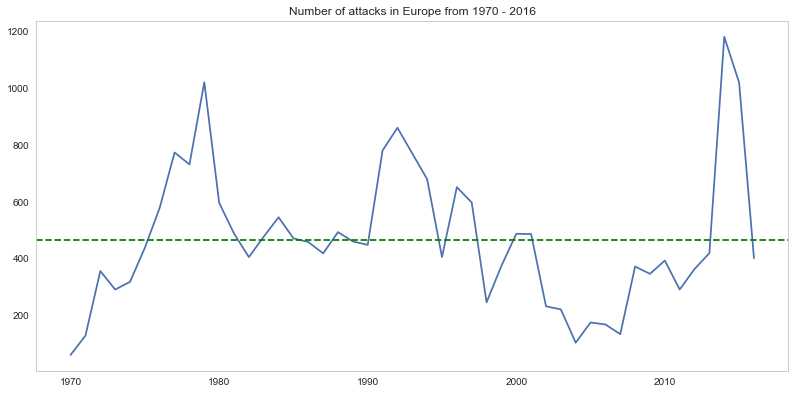

In [495]:
plotData = europe['Year'].value_counts().sort_index()

with sns.axes_style("whitegrid"):
    g = plotData.plot()
    g.grid(False)
    plt.axhline(y=europeYearlyMean, color='g', linestyle='--')
    plt.title("Number of attacks in Europe from 1970 - 2016")


/Users/mihailojoksimovic/miniconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5,1,'Top 10 countries with highest number of attacks')

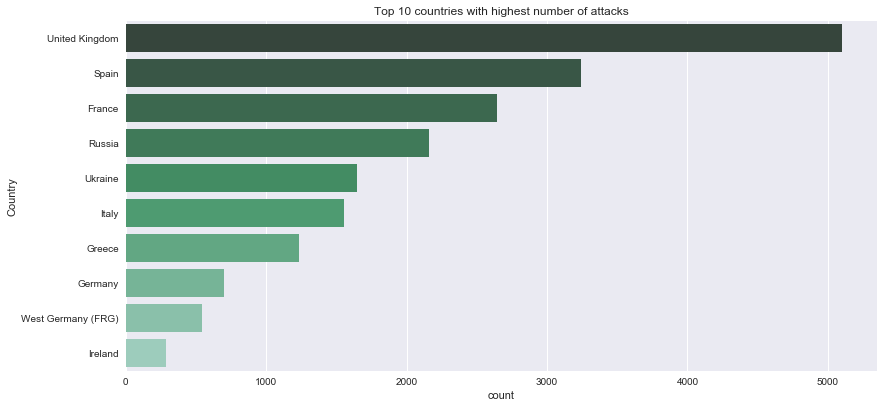

In [496]:
sns.countplot(y='Country', data=europe, order=europe['Country'].value_counts().index[:10], palette="BuGn_d")
plt.title("Top 10 countries with highest number of attacks")

/Users/mihailojoksimovic/miniconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


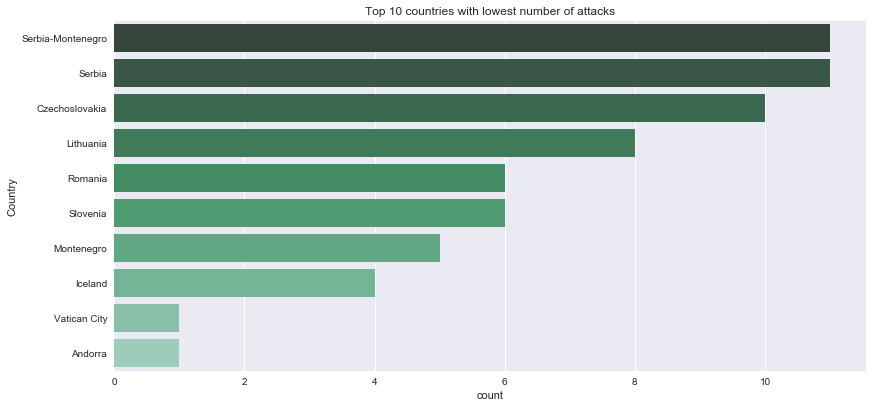

In [497]:
# Countries with least number of attacks
sns.countplot(y='Country', data=europe, order=europe['Country'].value_counts().index[-10:], palette="BuGn_d")
plt.title("Top 10 countries with lowest number of attacks");

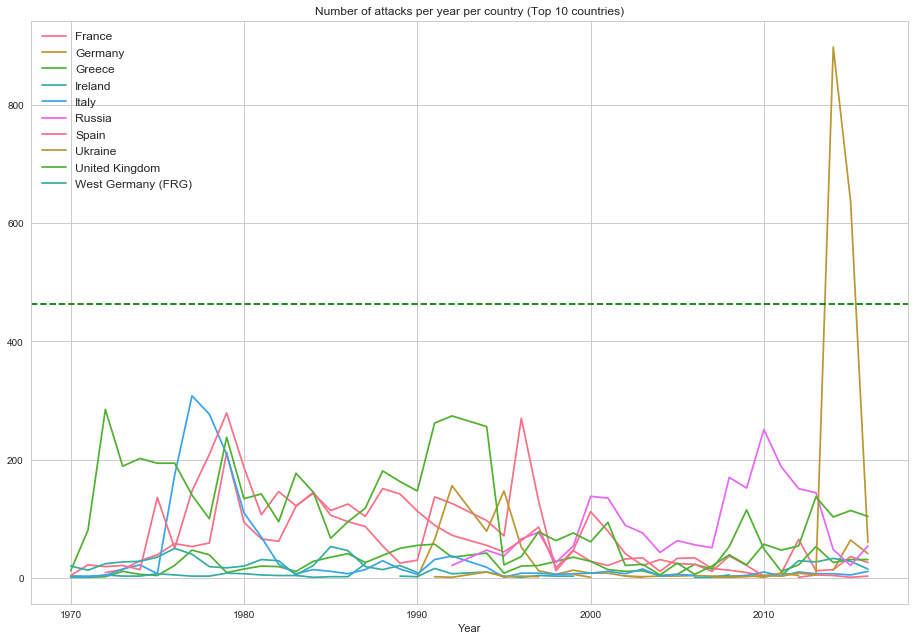

In [498]:
topTenCountries = europe['Country'].value_counts()[:10]
topTenCountriesDataframe = europe[europe['Country'].isin(topTenCountries.index)]
with sns.axes_style("whitegrid"):
    topTenCountriesDataframe.groupby(['Year','Country'])['Country'].count().sort_values().unstack().plot(figsize=(14, 10), color=sns.color_palette("husl"))
    plt.legend(fontsize="medium")
    plt.title("Number of attacks per year per country (Top 10 countries)")
    plt.axhline(y=europeYearlyMean, color='g', linestyle='--')

## Top 10 countries in last 10 years, grouped by year

In [499]:
lastTenYears = europe[europe.FullDateTime.dt.year >= 2008]

/Users/mihailojoksimovic/miniconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


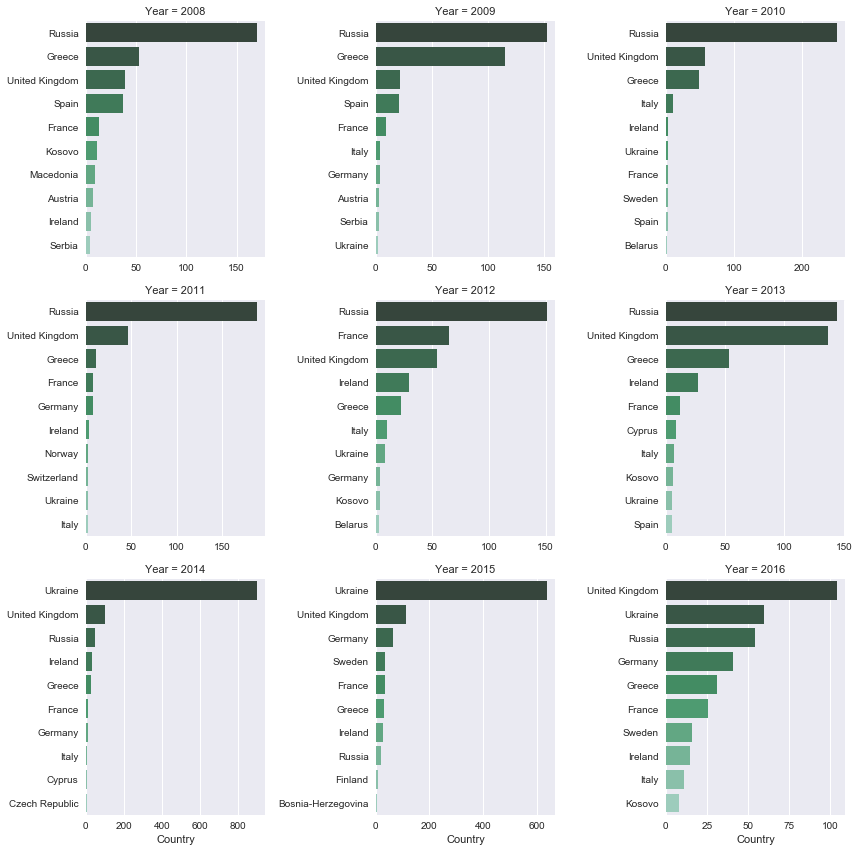

In [500]:
# Define a custom mapping function so that we can plot only top 10 countries
def countplot(data, **kwargs):
    sns.countplot(y=data, order=data.value_counts().index[:10], palette="BuGn_d")

grid = sns.FacetGrid(lastTenYears, col='Year', col_wrap=3, size=4, aspect=1, sharey=False, sharex=False)
grid.map(countplot, "Country")

## Number of attacks on monthly basis

Checking if there is any relation between a month and number of attacks (i.e. if warmer months are more prone to attacks)

/Users/mihailojoksimovic/miniconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


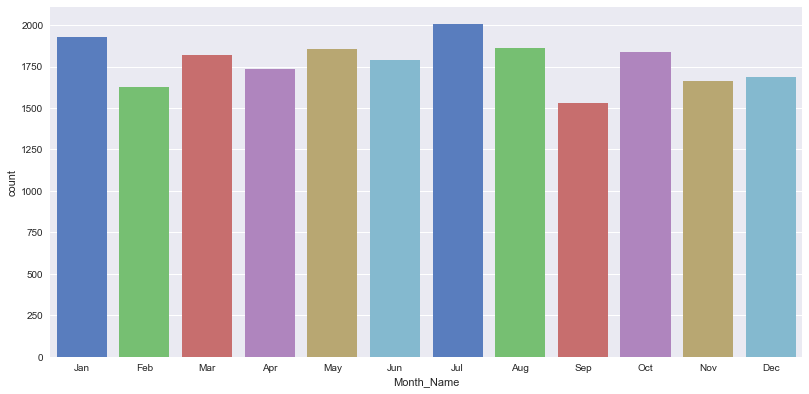

In [529]:
ax = sns.countplot(x='Month_Name', data=europe, palette='muted')

There doesn't seem to be any trend here ... Let's see if there is a trend if we group by year?

/Users/mihailojoksimovic/miniconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


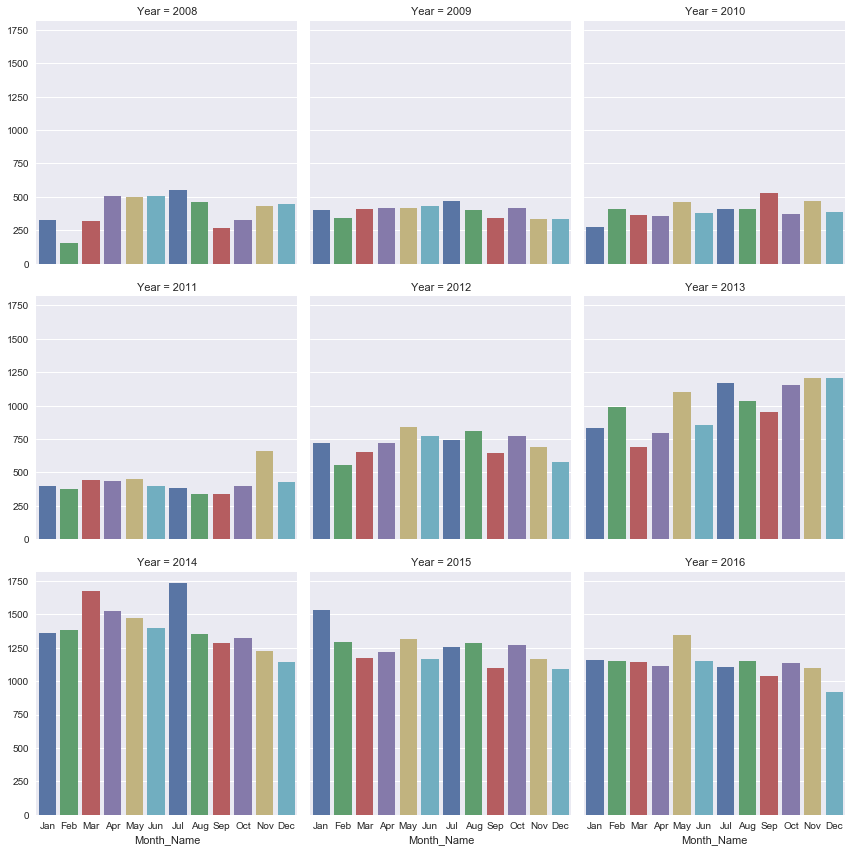

In [511]:
g = sns.FacetGrid(data[data['Year'] >= 2008], col='Year', col_wrap=3, size=4)
g.map(sns.countplot, 'Month_Name', palette=sns.color_palette())

There doesn't seem to be anything interesting there ... Let's try plotting the regional data now

## Regional data

In [671]:
europe['Region'].value_counts()

Western Europe    16307
Eastern Europe     5031
Name: Region, dtype: int64

/Users/mihailojoksimovic/miniconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


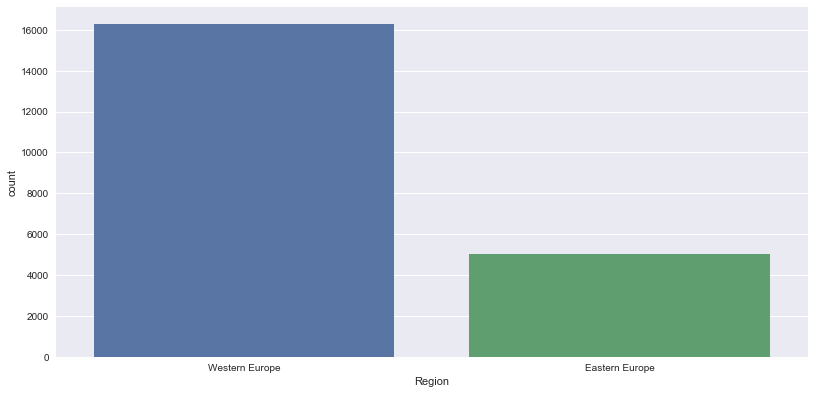

In [534]:
sns.countplot(europe['Region'])

That gives an interesting clue ... So number of attacks in Western Europe is way higher than in Eastern europe. Let's explore that further.

Let's start with drawing a trend and see if and how has this changed over time.

In [564]:
europeGroupedByRegion = europe.groupby(['Year', 'Region'])['Region'].count().unstack()

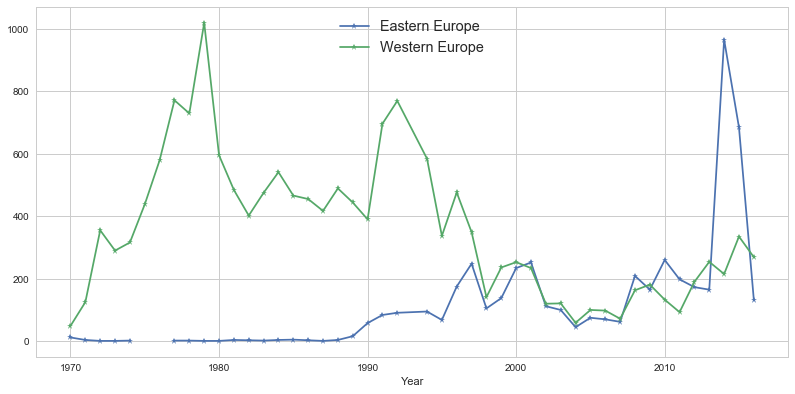

In [795]:
with sns.axes_style("whitegrid"):
    europeGroupedByRegion.plot(marker='*')
    plt.legend(fontsize="large")

So it seems that around 2016 or so something serious has happened, according to the spike. Let's see when/were that spike happened

In [552]:
europe[(europe['Region'] == 'Eastern Europe') & (europe['Year'] > 2010)].groupby('Year')['Year'].count()

Year
2011    198
2012    173
2013    165
2014    965
2015    684
2016    132
Name: Year, dtype: int64

So seems like 2014 and 2015th were interesting. Let's plot the data in separate figures and try drawing the trend line

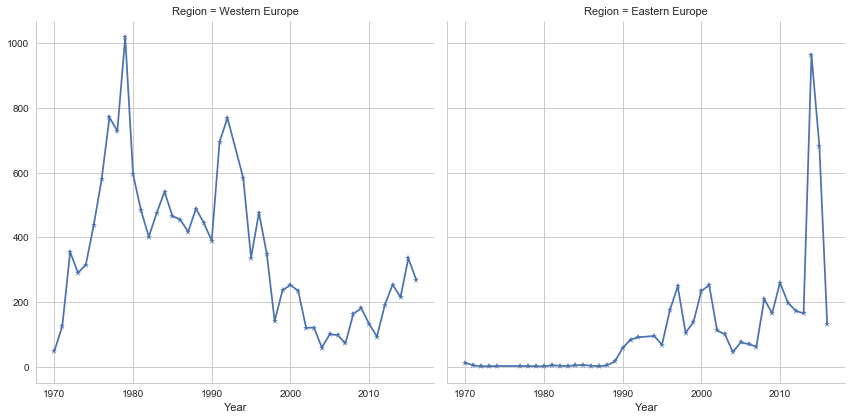

In [799]:
def countplot(x, **kwargs):
    x.value_counts().sort_index().plot(marker='*', **kwargs)

with sns.axes_style("whitegrid"):
    g = sns.FacetGrid(europe, col='Region', size=6)
    g.map(countplot, 'Year')

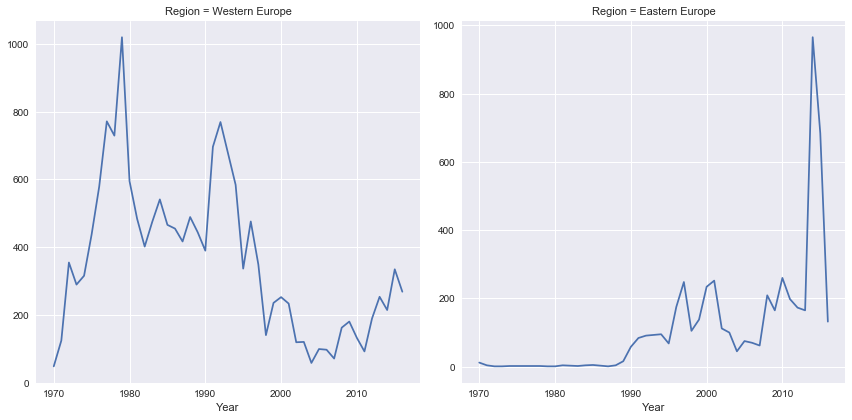

In [772]:
def countplot(x, **kwargs):
    x.value_counts().sort_index().plot(**kwargs)

g = sns.FacetGrid(europe, col='Region', sharex=False, sharey=False, size=6)
g.map(countplot, 'Year')

In [670]:
sns.FacetGrid.map_dataframe??

In [718]:
sns.color_palette()

[(0.29803921568627451, 0.44705882352941179, 0.69019607843137254),
 (0.33333333333333331, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.30588235294117649, 0.32156862745098042),
 (0.50588235294117645, 0.44705882352941179, 0.69803921568627447),
 (0.80000000000000004, 0.72549019607843135, 0.45490196078431372),
 (0.39215686274509803, 0.70980392156862748, 0.80392156862745101)]

In [753]:
sns.axes_style?